# This file compares and analyses the IMBI_Marko miner

In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, 'C:/Users/Marko/Desktop/GIt/IMBI_Master')

In [2]:
from local_pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.log.importer.xes import importer as xes_importer
from local_pm4py.algo.analysis import custom_enum
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py import view_petri_net
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py import precision_alignments
from pm4py import precision_token_based_replay
from pm4py import discover_petri_net_heuristics
from pm4py.convert import convert_to_petri_net
from pm4py.algo.discovery.inductive import algorithm as pm4py_algorithm
from pm4py.algo.discovery.inductive.variants import imf as pm4py_imf
import pandas as pd
from pm4py.algo.discovery.inductive.algorithm import Variants as ind_Variants
from local_pm4py.algo.analysis import Optimzation_Goals
import matplotlib.pyplot as plt
import numpy as np
import math
import fpdf
from PIL import Image
import os

In [3]:
def f1_score(a, b):
  # try: catch
  if math.isclose(a+b,0):
    return 0
  return 2 * (a * b) / (a + b)

In [4]:
def visualize_cuts(fileName):
  pdf = fpdf.FPDF(format='letter') #pdf format
  pdf.add_page() #create new page
  pdf.set_font("Arial", size=8) # font and textsize

  depth = 0
  currentIteration = 1
  file_path = "imbi_cuts/depth_" + str(depth) + "_It_" + str(currentIteration)
  
  folder_name = "imbi_cuts"
  # Check if the folder already exists
  if not os.path.exists(folder_name):
      # Create the folder
      os.makedirs(folder_name)
    
  # for depth
  while(os.path.isfile(file_path + ".png")):
    # for iteration
    while(os.path.isfile(file_path + ".png")):
      with open(file_path + ".txt") as f:
        pdf.cell(100, 4, txt="Cut: " + str(depth + 1) + " it: " + str(currentIteration), ln=1, align="C")
        pdf.cell(1000, 4, txt="cut | type | cost_p | cost_m | cost_ratio | fitP", ln=1, align="L")
        pdf.cell(1000, 4, txt="", ln=1, align="L")
        lines = f.readlines()
        readLines = 0
        for line in lines:
          if readLines == 0:
            outputLine = line.replace(" ", " | ")
          else:
            outputLine = line
          pdf.cell(1000, 4, txt=outputLine, ln=1, align="L")
          readLines += 1
          if readLines == 3:
            readLines = 0
            pdf.cell(1000, 4, txt="", ln=1, align="L")
      img = Image.open(file_path + ".png")
      width,height = img.size
      # print(width, height)
      pdf.image(file_path + ".png",w=min(150,width/3),h=min(150,height/3))
      pdf.add_page()
      currentIteration += 1
      file_path = "imbi_cuts/depth_" + str(depth) + "_It_" + str(currentIteration)
      
    depth += 1
    currentIteration = 1
    file_path = "imbi_cuts/depth_" + str(depth) + "_It_" + str(currentIteration)
  pdf.output(fileName + ".pdf")

In [5]:
def visualize_petriNet(df, miner, logPName, logMName = ""):
  df_temp = df[df["miner"] == miner]
  df_temp = df_temp[df_temp["logM_Name"] == logMName]
  df_temp = df_temp[df_temp["logP_Name"] == logPName]
  for net, im, fm in zip(df_temp.net, df_temp.im, df_temp.fm):
    print("Displaying: " + str(miner) + " " + str(logPName) + " " + str(logMName))
    view_petri_net(net, im, fm)

In [6]:
def visualize_All_petriNet(df, miner):
  df_temp = df[df["miner"] == miner]
  for logPName, logMName in zip(df_temp.logP_Name, df_temp.logM_Name):
    visualize_petriNet(df,miner,logPName,logMName)

In [7]:
def isRowPresent(df, miner, logPName, logMName, imf_noiseThreshold, hm_dependency_threshold, im_bi_sup, im_bi_ratio):
  dftemp = df[df["miner"] == miner]
  dftemp = dftemp[dftemp["logP_Name"] == logPName]
  dftemp = dftemp[dftemp["logM_Name"] == logMName]
  dftemp = dftemp[dftemp["imf_noise_thr"] == imf_noiseThreshold]
  dftemp = dftemp[dftemp["hm_depen_thr"] == hm_dependency_threshold]
  dftemp = dftemp[dftemp["im_bi_sup"] == im_bi_sup]
  dftemp = dftemp[dftemp["im_bi_ratio"] == im_bi_ratio]
  if len(dftemp.index) > 0:
    return True
  return False


In [8]:
def runDoubleLogEvaluation(df,log,logM, name,net, im, fm, logPName = "",logMName = "", imf_noiseThreshold = 0, hm_dependency_threshold = 0,im_bi_sup = 0, im_bi_ratio = 0):
  mes = Optimzation_Goals.apply_petri(log,logM,net,im,fm)

  df = pd.concat([df, pd.DataFrame.from_records([{
    "miner" : name,
    "logP_Name": logPName[:logPName.rfind(".")],
    "logM_Name": logMName[:logMName.rfind(".")],
    "imf_noise_thr" : imf_noiseThreshold,
    "hm_depen_thr" : hm_dependency_threshold,
    "im_bi_sup" : im_bi_sup,
    "im_bi_ratio" : im_bi_ratio,
    "acc_logs": mes['acc'],
    "fitP" : mes['fitP'],
    "fitM" : mes['fitM'],
    "f1_fit_logs": mes['F1'],
    "precP" : mes['precision'],
    "net": net,
    "im" : im,
    "fm" : fm
  }])])
  return df

In [9]:
def runSingleLogEvaluation(df,log,logM, name, net, im, fm, logPName = "",logMName = "", imf_noiseThreshold = 0, hm_dependency_threshold = 0,im_bi_sup = 0, im_bi_ratio = 0, pruning_threshold = 0):
  
  # if isRowPresent(df, name, logPName, logMName, imf_noiseThreshold, hm_dependency_threshold, im_bi_sup, im_bi_ratio) == True:
  #   print ("Skipped because present")
  #   return df
  
  parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT:"pdf"}
  gviz = pn_visualizer.apply(net, im, fm, parameters=parameters)

  try:
    fitness_token = replay_fitness_evaluator.apply(log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)["log_fitness"]
  except:
    fitness_token = 0
  try:
    fitness_align = replay_fitness_evaluator.apply(log, net, im, fm, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)["log_fitness"]
  except:
    fitness_align = 0
    
  try:
    prec_token = precision_token_based_replay(log, net, im, fm)
  except:
    prec_token = 0
    
  try:
    prec_alignment = precision_alignments(log, net, im, fm)
  except:
    prec_alignment = 0
    

  df = pd.concat([df, pd.DataFrame.from_records([{
      "miner" : name,
      "logP_Name": logPName,
      "logM_Name": logMName,
      "imf_noise_thr" : imf_noiseThreshold,
      "hm_depen_thr" : hm_dependency_threshold,
      "im_bi_sup" : im_bi_sup,
      "im_bi_ratio" : im_bi_ratio,
      "pruning_threshold" : pruning_threshold,
      "fit_tok": fitness_token,
      "fit_alig": fitness_align,
      "prec_tok": prec_token,
      "prec_alig": prec_alignment,
      "f1_tok": f1_score(fitness_token, prec_token),
      "f1_alig": f1_score(fitness_align, prec_alignment),
      "net": net,
      "im" : im,
      "fm" : fm
  }])])
  return df

In [10]:
def add_Model_To_Database(df,log,logM, name,net, im, fm, logPName = "",logMName = "", imf_noiseThreshold = 0, hm_dependency_threshold = 0,im_bi_sup = 0, im_bi_ratio = 0, pruning_threshold = 0):
  if logMName == "":
    df = runSingleLogEvaluation(df,log,logM, name,net, im, fm, logPName,logMName, imf_noiseThreshold, hm_dependency_threshold,im_bi_sup, im_bi_ratio, pruning_threshold)
  else:
    df = runDoubleLogEvaluation(df,log,logM, name,net, im, fm, logPName,logMName, imf_noiseThreshold, hm_dependency_threshold,im_bi_sup, im_bi_ratio, pruning_threshold)
  return df

In [11]:
def getF1Value(df, miner, logPName, logMName, support, ratio):
  dftemp = df[df["miner"] == miner]
  dftemp = dftemp[dftemp["logP_Name"] == logPName[:logPName.rfind(".")]]
  dftemp = dftemp[dftemp["logM_Name"] == logMName[:logPName.rfind(".")]]
  dftemp = dftemp[dftemp["im_bi_sup"] == support]
  dftemp = dftemp[dftemp["im_bi_ratio"] == ratio]
  if len(dftemp.index) > 1:
    raise Exception("Error, too many rows.")
  return dftemp["f1_fit_logs"].iloc[0]


In [12]:
def applyMinerToLog(df, logPathP, logPathM,logPName, logMName = "", noiseThreshold = 0.0, dependency_threshold=0.0, support = 0, ratio = 0, pruning_threshold = 0):
  logP = xes_importer.apply(logPathP)
  if logMName == "":
    logM = logP
    # inductive miner
    print("Running IM")
    pt = pm4py_algorithm.apply(logP,variant=ind_Variants.IM)
    net, im, fm = convert_to_petri_net(pt)
    df = add_Model_To_Database(df=df, log=logP, logM=logM,net=net,im=im,fm=fm,name="IM",logPName=logPName, im_bi_sup=support,im_bi_ratio=ratio,pruning_threshold = pruning_threshold)
    
    #imf 
    print("Running IMF")
    parameters = {pm4py_imf.IMFParameters.NOISE_THRESHOLD : noiseThreshold}
    pt = pm4py_algorithm.apply(logP,variant=ind_Variants.IMf, parameters=parameters)
    net, im, fm = convert_to_petri_net(pt)
    df = add_Model_To_Database(df=df, log=logP, logM=logM,net=net,im=im,fm=fm,name="IMF",logPName=logPName,imf_noiseThreshold=noiseThreshold, im_bi_sup=support,im_bi_ratio=ratio,pruning_threshold = pruning_threshold)
    
    #hm
    print("Running HM")
    net, im, fm = discover_petri_net_heuristics(logP,dependency_threshold=dependency_threshold)
    df = add_Model_To_Database(df=df, log=logP, logM=logM,net=net,im=im,fm=fm,name="HM",logPName=logPName,hm_dependency_threshold=dependency_threshold, im_bi_sup=support,im_bi_ratio=ratio,pruning_threshold = pruning_threshold)
  else:
    logM = xes_importer.apply(logPathM)
    
  # imbi_ali
  print("Running IMbi_ali")
  cost_Variant = custom_enum.Cost_Variant.ACTIVITY_FREQUENCY_SCORE
  net, im, fm = inductive_miner.apply_bi(logP,logM, variant=inductive_miner.Variants.IMbi, sup=support, ratio=ratio, pruning_threshold = pruning_threshold, size_par=len(logP)/len(logM), cost_Variant=cost_Variant)
  df = add_Model_To_Database(df=df,log=logP, logM=logM,net=net,im=im,fm=fm,name="IMbi_ali",logPName=logPName, logMName=logMName,im_bi_sup=support,im_bi_ratio=ratio,pruning_threshold = pruning_threshold)
  
  fileName_cuts_ali = "cuts_IMbi_ali_sup_" + str(support) + "_ratio_" + str(ratio) + "_logP_" + logPName[:logPName.rfind(".")] + "_logM_" + logMName[:logMName.rfind(".")]
  visualize_cuts(fileName_cuts_ali)
  
  for f in os.listdir("imbi_cuts"):
    os.remove(os.path.join("imbi_cuts", f))
  
  #imbi_mar
  print("Running IMbi_mar")
  cost_Variant = custom_enum.Cost_Variant.ACTIVITY_RELATION_SCORE
  net, im, fm = inductive_miner.apply_bi(logP,logM, variant=inductive_miner.Variants.IMbi, sup=support, ratio=ratio, pruning_threshold = pruning_threshold, size_par=len(logP)/len(logM), cost_Variant=cost_Variant)
  df = add_Model_To_Database(df=df, log=logP, logM=logM,net=net,im=im,fm=fm,name="IMbi_mar",logPName=logPName, logMName=logMName, im_bi_sup=support,im_bi_ratio=ratio,pruning_threshold = pruning_threshold)
  
  fileName_cuts_mar = "cuts_IMbi_mar_sup_" + str(support) + "_ratio_" + str(ratio) + "_logP-" + logPName[:logPName.rfind(".")] + "_logM-" + logMName[:logMName.rfind(".")]
  visualize_cuts(fileName_cuts_mar)
  
  for f in os.listdir("imbi_cuts"):
    os.remove(os.path.join("imbi_cuts", f))
  
  # for double log
  marImproved = False
  if logMName != "":
    f1_ali = getF1Value(df,"IMbi_ali",logPName,logMName,support,ratio)
    f1_mar = getF1Value(df,"IMbi_mar",logPName,logMName,support,ratio)
    if f1_ali < f1_mar:
      display("Mar > Ali")
      marImproved = True
      if True:
        if os.path.exists(fileName_cuts_ali+ ".pdf"):
          os.remove(fileName_cuts_ali+ ".pdf")
        if os.path.exists(fileName_cuts_mar+ ".pdf"):
          os.remove(fileName_cuts_mar + ".pdf")
    else:
      display("Ali > Mar")
  return df, marImproved

In [13]:
columns = ["miner", "logP_Name", "logM_Name","imf_noise_thr","hm_depen_thr","im_bi_sup","im_bi_ratio", "fit_tok", "fit_alig", "prec_tok", "prec_alig", "f1_tok", "f1_alig", "net", "im", "fm"]
df = pd.DataFrame(data=None, index=None, columns=columns, dtype=None, copy=None)

In [14]:
rootPath = "C:/Users/Marko/Desktop/IMbi_Data/analysing/"

lpNames = ["lp_2012.xes", "lp_2017.xes", "lp_2018.xes"]
# lpNames = ["lp_2012.xes"]

lMNames = ["lm_2012.xes", "lm_2017.xes", "lm_2018.xes"]
# lMNames = ["lm_2012.xes"]
lpPaths = []
lmPaths = []

for lp in lpNames:
  lpPaths.append((lp,rootPath + lp))
for lm in lMNames:
  lmPaths.append((lm,rootPath + lm))
  

In [15]:
runSingleLog = True

ratios = [0]
sups = [0.2, 0.4]
pruning_thresholds = [0, 0.1, 0.2]
runs = 1

totalRuns = len(lpPaths) * len(ratios) * len(sups) * len(pruning_thresholds)
if runSingleLog:
  for i in range(0,len(lpPaths)):
    for ratio in ratios:
      for sup in sups:
        for pruning_threshold in pruning_thresholds:
          display("Running: " + lpPaths[i][0] + " " + str(runs) + "/" + str(totalRuns))
          display("i: " + str(i) + " ratio: " + str(ratio) + " sup: " + str(sup) + " pruning: " + str(pruning_threshold))
          df, marImproved = applyMinerToLog(df, lpPaths[i][1], "", lpPaths[i][0],"", 0.2, 0.99, sup, ratio, pruning_threshold)
          runs += 1

'Running: lp_2012.xes 1/18'

'i: 0 ratio: 0 sup: 0.2 pruning: 0'

c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\util\dt_parsing\parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 10556/10556 [00:01<00:00, 8012.14it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 378.78it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1622.64it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 789.01it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1698.32it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 351.02it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 2605.99it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 905.30it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1284.31it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 641.79it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 2263.24it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 905.24it/s]


'Running: lp_2012.xes 2/18'

'i: 0 ratio: 0 sup: 0.2 pruning: 0.1'

parsing log, completed traces :: 100%|██████████| 10556/10556 [00:01<00:00, 8305.28it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 396.83it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1592.68it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 796.30it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1720.06it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 826.93it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 2529.38it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 895.87it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1283.57it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 641.80it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 2097.54it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 895.80it/s]


'Running: lp_2012.xes 3/18'

'i: 0 ratio: 0 sup: 0.2 pruning: 0.2'

parsing log, completed traces :: 100%|██████████| 10556/10556 [00:01<00:00, 9010.67it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 378.78it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1592.57it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 789.27it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1686.29it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 843.12it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 2529.42it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 886.64it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1343.71it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 728.84it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 2205.05it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 877.56it/s]


'Running: lp_2012.xes 4/18'

'i: 0 ratio: 0 sup: 0.4 pruning: 0'

parsing log, completed traces :: 100%|██████████| 10556/10556 [00:01<00:00, 9092.17it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 378.79it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1622.67it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 811.33it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1653.86it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 851.45it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 2528.67it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 826.93it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 2263.21it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 803.73it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 3583.31it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1011.76it/s]


'Running: lp_2012.xes 5/18'

'i: 0 ratio: 0 sup: 0.4 pruning: 0.1'

parsing log, completed traces :: 100%|██████████| 10556/10556 [00:01<00:00, 8132.51it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 393.72it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1535.68it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 367.52it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1755.06it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 868.70it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 2457.25it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 868.64it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 2263.21it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 796.30it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 3185.53it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1048.81it/s]


'Running: lp_2012.xes 6/18'

'i: 0 ratio: 0 sup: 0.4 pruning: 0.2'

parsing log, completed traces :: 100%|██████████| 10556/10556 [00:01<00:00, 7969.79it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 373.13it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1535.76it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 789.01it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1686.30it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 352.46it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 2457.12it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 924.74it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 2326.56it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 886.94it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 3583.31it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1023.85it/s]


'Running: lp_2017.xes 7/18'

'i: 1 ratio: 0 sup: 0.2 pruning: 0'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 1705.39it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 446/446 [00:11<00:00, 40.13it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 550.65it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:14<00:00, 82.87it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 1502.51it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 400.67it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 2378.98it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 687.30it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 1796.26it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 664.27it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 2858.17it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 805.11it/s]


'Running: lp_2017.xes 8/18'

'i: 1 ratio: 0 sup: 0.2 pruning: 0.1'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 1549.89it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 446/446 [00:10<00:00, 40.56it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 539.94it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:13<00:00, 85.72it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 1494.08it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 411.04it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 2380.02it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 682.65it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 2053.45it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 718.72it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 2424.67it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 740.74it/s]


'Running: lp_2017.xes 9/18'

'i: 1 ratio: 0 sup: 0.2 pruning: 0.2'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 1540.04it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 446/446 [00:11<00:00, 40.27it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 556.76it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:13<00:00, 85.99it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 1495.02it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:03<00:00, 343.55it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 2367.31it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 686.12it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 3307.58it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 845.26it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 2986.17it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 817.76it/s]


'Running: lp_2017.xes 10/18'

'i: 1 ratio: 0 sup: 0.4 pruning: 0'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 1552.80it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 446/446 [00:11<00:00, 39.39it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 544.13it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:14<00:00, 85.21it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 1506.28it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 401.54it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 2303.56it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 665.49it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 3372.70it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 784.17it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 2897.00it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 893.75it/s]


'Running: lp_2017.xes 11/18'

'i: 1 ratio: 0 sup: 0.4 pruning: 0.1'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 1547.59it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 446/446 [00:11<00:00, 39.77it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 555.61it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:14<00:00, 85.30it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 1497.28it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 412.10it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 2395.60it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 693.01it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 2885.68it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 786.75it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 3023.96it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 838.92it/s]


'Running: lp_2017.xes 12/18'

'i: 1 ratio: 0 sup: 0.4 pruning: 0.2'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 1543.21it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 446/446 [00:11<00:00, 39.98it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 559.63it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:13<00:00, 85.76it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 1501.56it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 413.80it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 2382.44it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 690.88it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 3475.38it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 819.83it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 1199/1199 [00:00<00:00, 3102.19it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 830.05it/s]


'Running: lp_2018.xes 13/18'

'i: 2 ratio: 0 sup: 0.2 pruning: 0'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 2235.47it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 197/197 [00:04<00:00, 40.75it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 503.69it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:16<00:00, 79.05it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 613.96it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:05<00:00, 264.88it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 1118.99it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 1104.54it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 527.34it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:00<00:00, 1334.42it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 545.34it/s]


'Running: lp_2018.xes 14/18'

'i: 2 ratio: 0 sup: 0.2 pruning: 0.1'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 2316.60it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 197/197 [00:04<00:00, 40.63it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 488.31it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:16<00:00, 79.01it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 635.31it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:05<00:00, 262.73it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 1113.82it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 1083.76it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 552.58it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 1324.67it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 621.08it/s]


'Running: lp_2018.xes 15/18'

'i: 2 ratio: 0 sup: 0.2 pruning: 0.2'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 2375.30it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 197/197 [00:04<00:00, 41.86it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 507.17it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:16<00:00, 78.49it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 629.93it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:05<00:00, 256.51it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 1121.35it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:00<00:00, 1344.15it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 583.16it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:00<00:00, 1338.78it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 552.43it/s]


'Running: lp_2018.xes 16/18'

'i: 2 ratio: 0 sup: 0.4 pruning: 0'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 2405.77it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 197/197 [00:04<00:00, 41.83it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 510.10it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:16<00:00, 79.75it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 640.71it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:05<00:00, 258.88it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 1123.05it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:00<00:00, 3138.33it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 804.24it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:00<00:00, 3435.25it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 791.64it/s]


'Running: lp_2018.xes 17/18'

'i: 2 ratio: 0 sup: 0.4 pruning: 0.1'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 2679.47it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 197/197 [00:04<00:00, 41.27it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 498.12it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:17<00:00, 77.90it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 634.91it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:05<00:00, 235.62it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 1074.55it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:00<00:00, 3709.34it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 851.81it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:00<00:00, 3709.09it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 840.57it/s]


'Running: lp_2018.xes 18/18'

'i: 2 ratio: 0 sup: 0.4 pruning: 0.2'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 2638.53it/s]


Running IM


aligning log, completed variants :: 100%|██████████| 197/197 [00:04<00:00, 41.11it/s]
c:\Users\Marko\AppData\Local\Programs\Python\Python38\lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 510.00it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:16<00:00, 79.53it/s]


Running IMF


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 620.21it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:05<00:00, 249.93it/s]


Running HM


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 1068.06it/s]


Running IMbi_ali


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:00<00:00, 3701.34it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 779.08it/s]


Running IMbi_mar


replaying log with TBR, completed variants :: 100%|██████████| 1326/1326 [00:00<00:00, 3417.56it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:01<00:00, 798.80it/s]


In [16]:
if runSingleLog == False:
  runs = 1
  improving_runs = 0
  
  ratios = [1, 0.8]
  sups = [0.2, 0.3]
  pruning_thresholds = [0,0.1,0.2]
  
  totalRuns = len(lpPaths) * len(ratios) * len(sups) * len(pruning_thresholds)

  for i in range(0,len(lpPaths)):
    for ratio in ratios:
      for sup in sups:
        for pruning_threshold in pruning_thresholds:
          display("Running: " + lpPaths[i][0] + " " + str(runs) + "/" + str(totalRuns))
          display("i: " + str(i) + " ratio: " + str(ratio) + " sup: " + str(sup) + " pruning: " + str(pruning_threshold))
          display("Stats: " + str(improving_runs) + "/" + str(runs))
          df, marImproved = applyMinerToLog(df, lpPaths[i][1], lmPaths[i][1], lpPaths[i][0],lmPaths[i][0], 0.2, 0.99, sup, ratio, pruning_threshold)
          if marImproved:
            improving_runs += 1
          runs += 1
  
# display(df)

In [17]:

def setupYTickList(minValue, step):
  res = []
  cur = 1
  while cur > minValue:
    res.append(cur)
    cur -= step
  res.append(cur)
  return res
    

def displayDoubleLog(df, saveFig = False):
  df_grouped = df.groupby(by=["logP_Name",	"logM_Name", "im_bi_sup", "im_bi_ratio", "pruning_threshold"], group_keys=True).apply(lambda x : x)
  
  numberOfPlotPerRow = 4
  rows = math.ceil(float(len(df_grouped.index.unique()))/numberOfPlotPerRow)
  cols = min(len(df_grouped.index.unique()),numberOfPlotPerRow)

  fig, axs = plt.subplots(rows, cols, figsize=(15 * (cols / numberOfPlotPerRow), 4 * rows), squeeze=False)
  fig.tight_layout(pad=10.0)
  cur_Row = 0
  cur_Col = 0
  for logGroup in df_grouped.index.unique():
    df_log_grouped = df_grouped.loc[logGroup]
    axs[cur_Row,cur_Col].set_title("LogP: " + logGroup[0] + " LogM: " + logGroup[1] + "\n" + "Sup: " + str(df_log_grouped.im_bi_sup[0]) + " ratio: " + str(df_log_grouped.im_bi_ratio[0]) + " Pruning: " + str(df_log_grouped.pruning_threshold[0]))
    axs[cur_Row,cur_Col].set_xlabel("Miners")
    j = 0
    xTickLabel = []
    idx = []
    minValue = 0
    for miner, acc, fitP, fitM, f1_fit in zip(df_log_grouped.miner, df_log_grouped.acc_logs, df_log_grouped.fitP, df_log_grouped.fitM, df_log_grouped.f1_fit_logs):
      minValue = min([minValue, acc, fitP, fitM, f1_fit])
      axs[cur_Row,cur_Col].bar(j,acc, color="r", label="acc")
      axs[cur_Row,cur_Col].bar(j+1,fitP, color="g", label="fitP")
      axs[cur_Row,cur_Col].bar(j+2,fitM, color="b", label="fitM")
      axs[cur_Row,cur_Col].bar(j+3,f1_fit, color="orange", label="f1_fit")
      xTickLabel.append(miner)
      idx.append(j + 1.5)
      j += 5
      
    
    axs[cur_Row,cur_Col].set_yticks(setupYTickList(minValue, 0.25))
    axs[cur_Row,cur_Col].set_xticks(idx)
    axs[cur_Row,cur_Col].set_xticklabels(xTickLabel)
    axs[cur_Row,cur_Col].legend(loc='center left', ncols=1, labels=["acc", "fitP", "fitM", "f1_fit"], bbox_to_anchor=(1, 0.5))
    cur_Col += 1
    
    if cur_Col == numberOfPlotPerRow:
      cur_Row += 1
      cur_Col = 0
      
  plt.show()

  if saveFig:
    fig.savefig("plot" + ".pdf")

In [18]:
def displaySingleLog(df, saveFig = False):
  df_grouped = df.groupby(by=["logP_Name",	"logM_Name", "im_bi_sup", "pruning_threshold"], group_keys=True).apply(lambda x : x)

  numberOfPlotPerRow = 3
  rows = math.ceil(float(len(df_grouped.index.unique()))/numberOfPlotPerRow)
  cols = min(len(df_grouped.index.unique()),numberOfPlotPerRow)
  

  for f1_measure in ["f1_tok", "f1_alig"]:
    fig, axs = plt.subplots(rows, cols, figsize=(15 * (cols / numberOfPlotPerRow), 4 * rows), squeeze=False)
    fig.tight_layout(pad=10.0)
    cur_Row = 0
    cur_Col = 0
    for logGroup in df_grouped.index.unique():
      df_log_grouped = df_grouped.loc[logGroup]
      axs[cur_Row,cur_Col].set_title("LogP: " + logGroup[0] + " LogM: " + logGroup[1] + "\n" + "Sup: " + str(df_log_grouped.im_bi_sup[0]) + " Pruning: " + str(df_log_grouped.pruning_threshold[0]))
      axs[cur_Row,cur_Col].set_ylabel(f1_measure)
      axs[cur_Row,cur_Col].set_xlabel("Miners")
      j = 0
      xTickLabel = []
      idx = []
      for miner, f1_tok in zip(df_log_grouped.miner, df_log_grouped[f1_measure]):
        axs[cur_Row,cur_Col].bar(j,f1_tok, label=str(miner))
        xTickLabel.append(miner)
        idx.append(j)
        j += 1
      axs[cur_Row,cur_Col].set_xticks(idx)
      axs[cur_Row,cur_Col].set_xticklabels(xTickLabel, rotation=90)
      cur_Col += 1
      if cur_Col == numberOfPlotPerRow:
        cur_Row += 1
        cur_Col = 0
        
    plt.show()
    if saveFig:
      fig.savefig("plot_" + f1_measure + ".pdf")

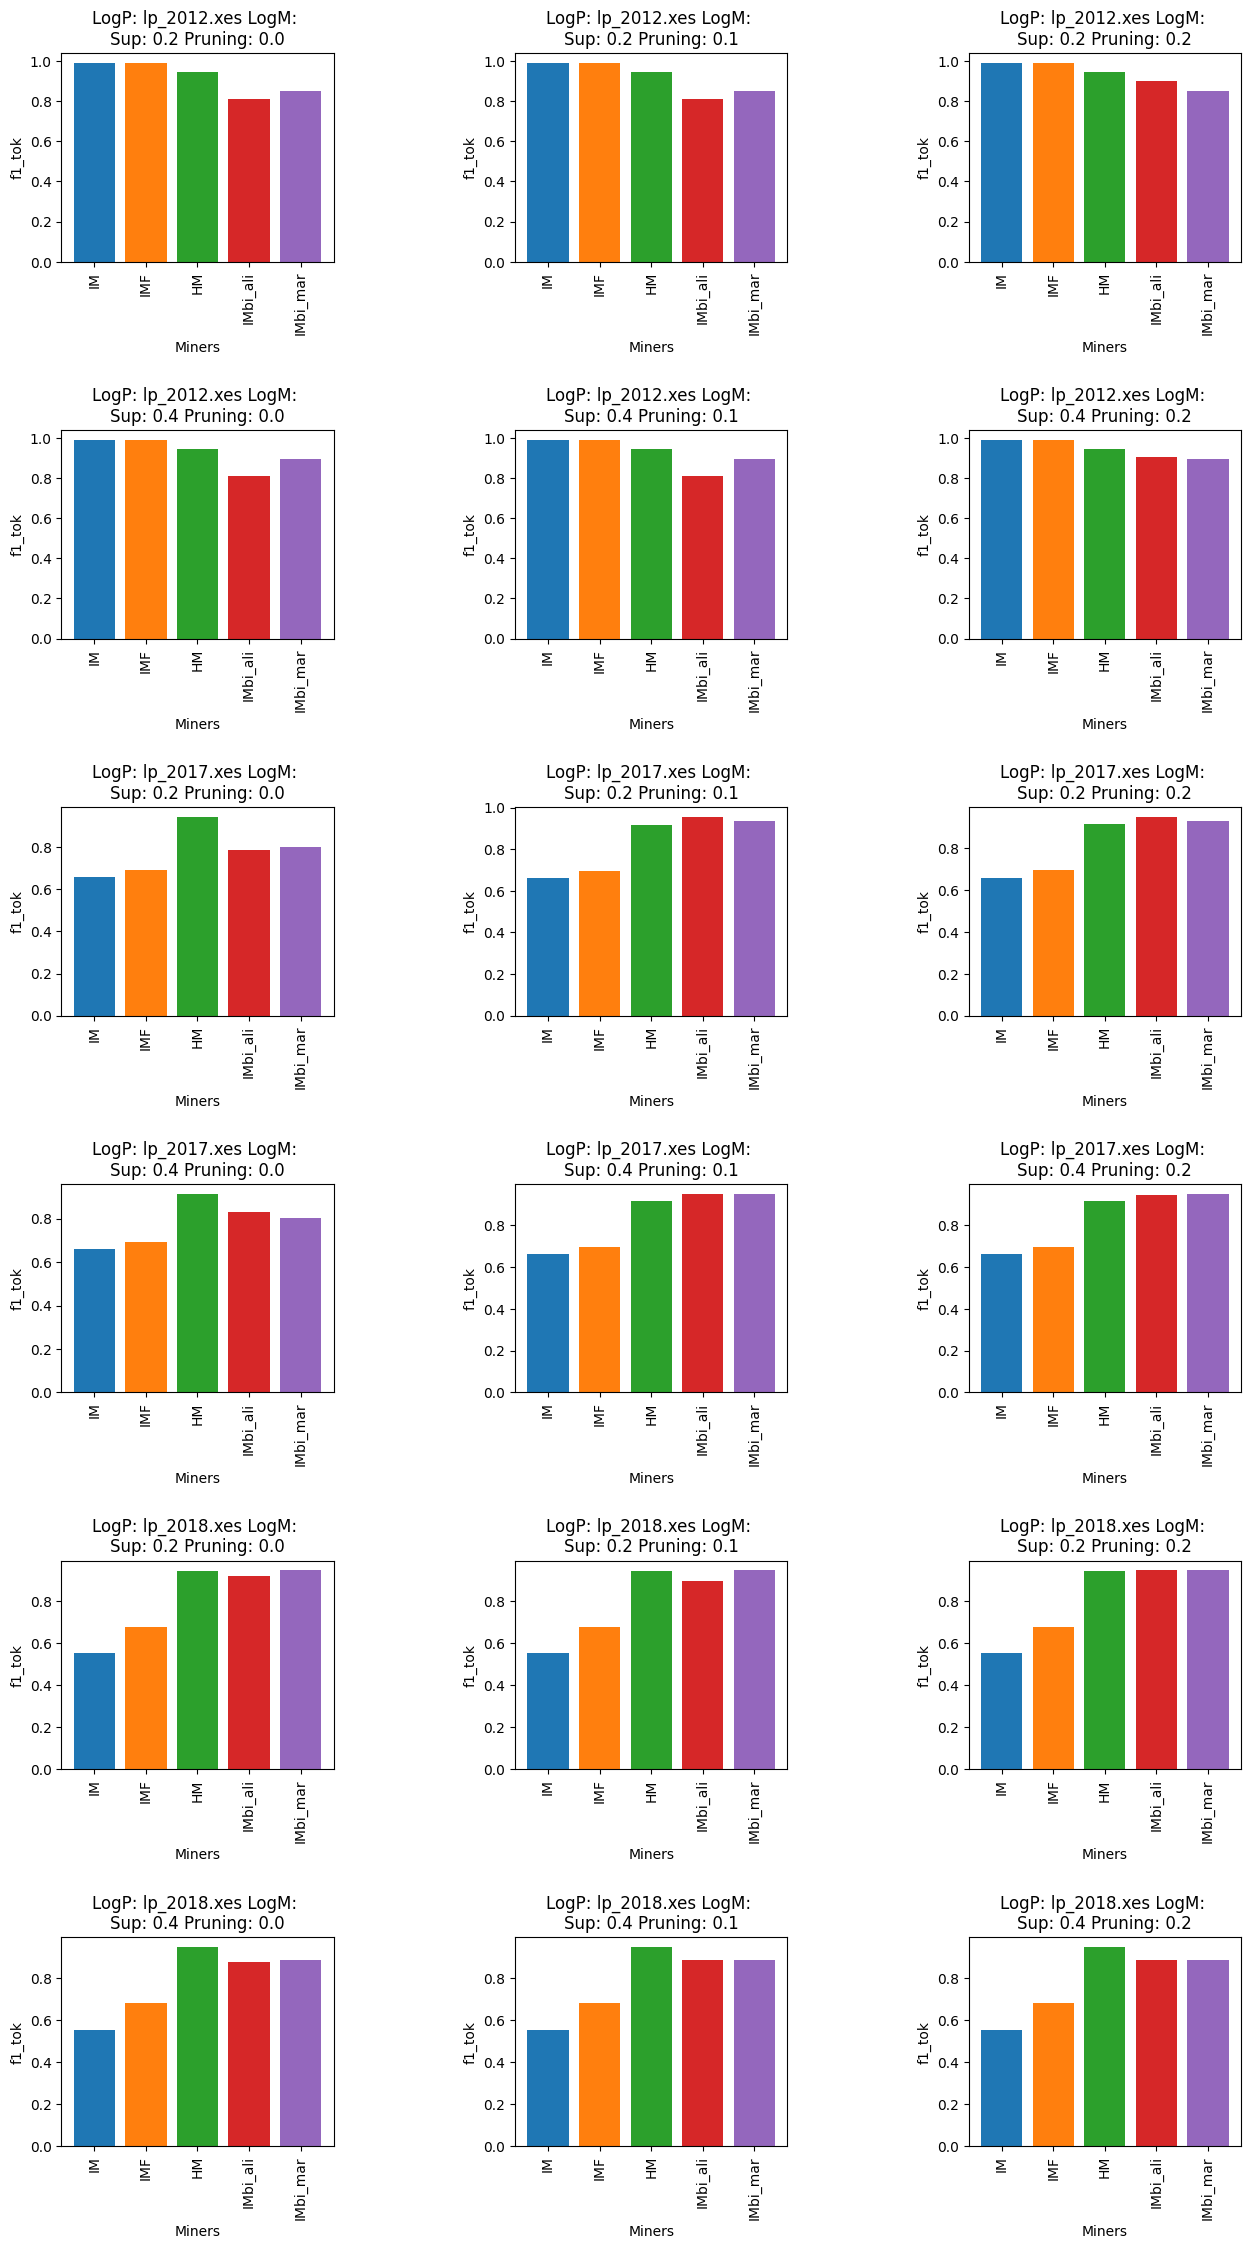

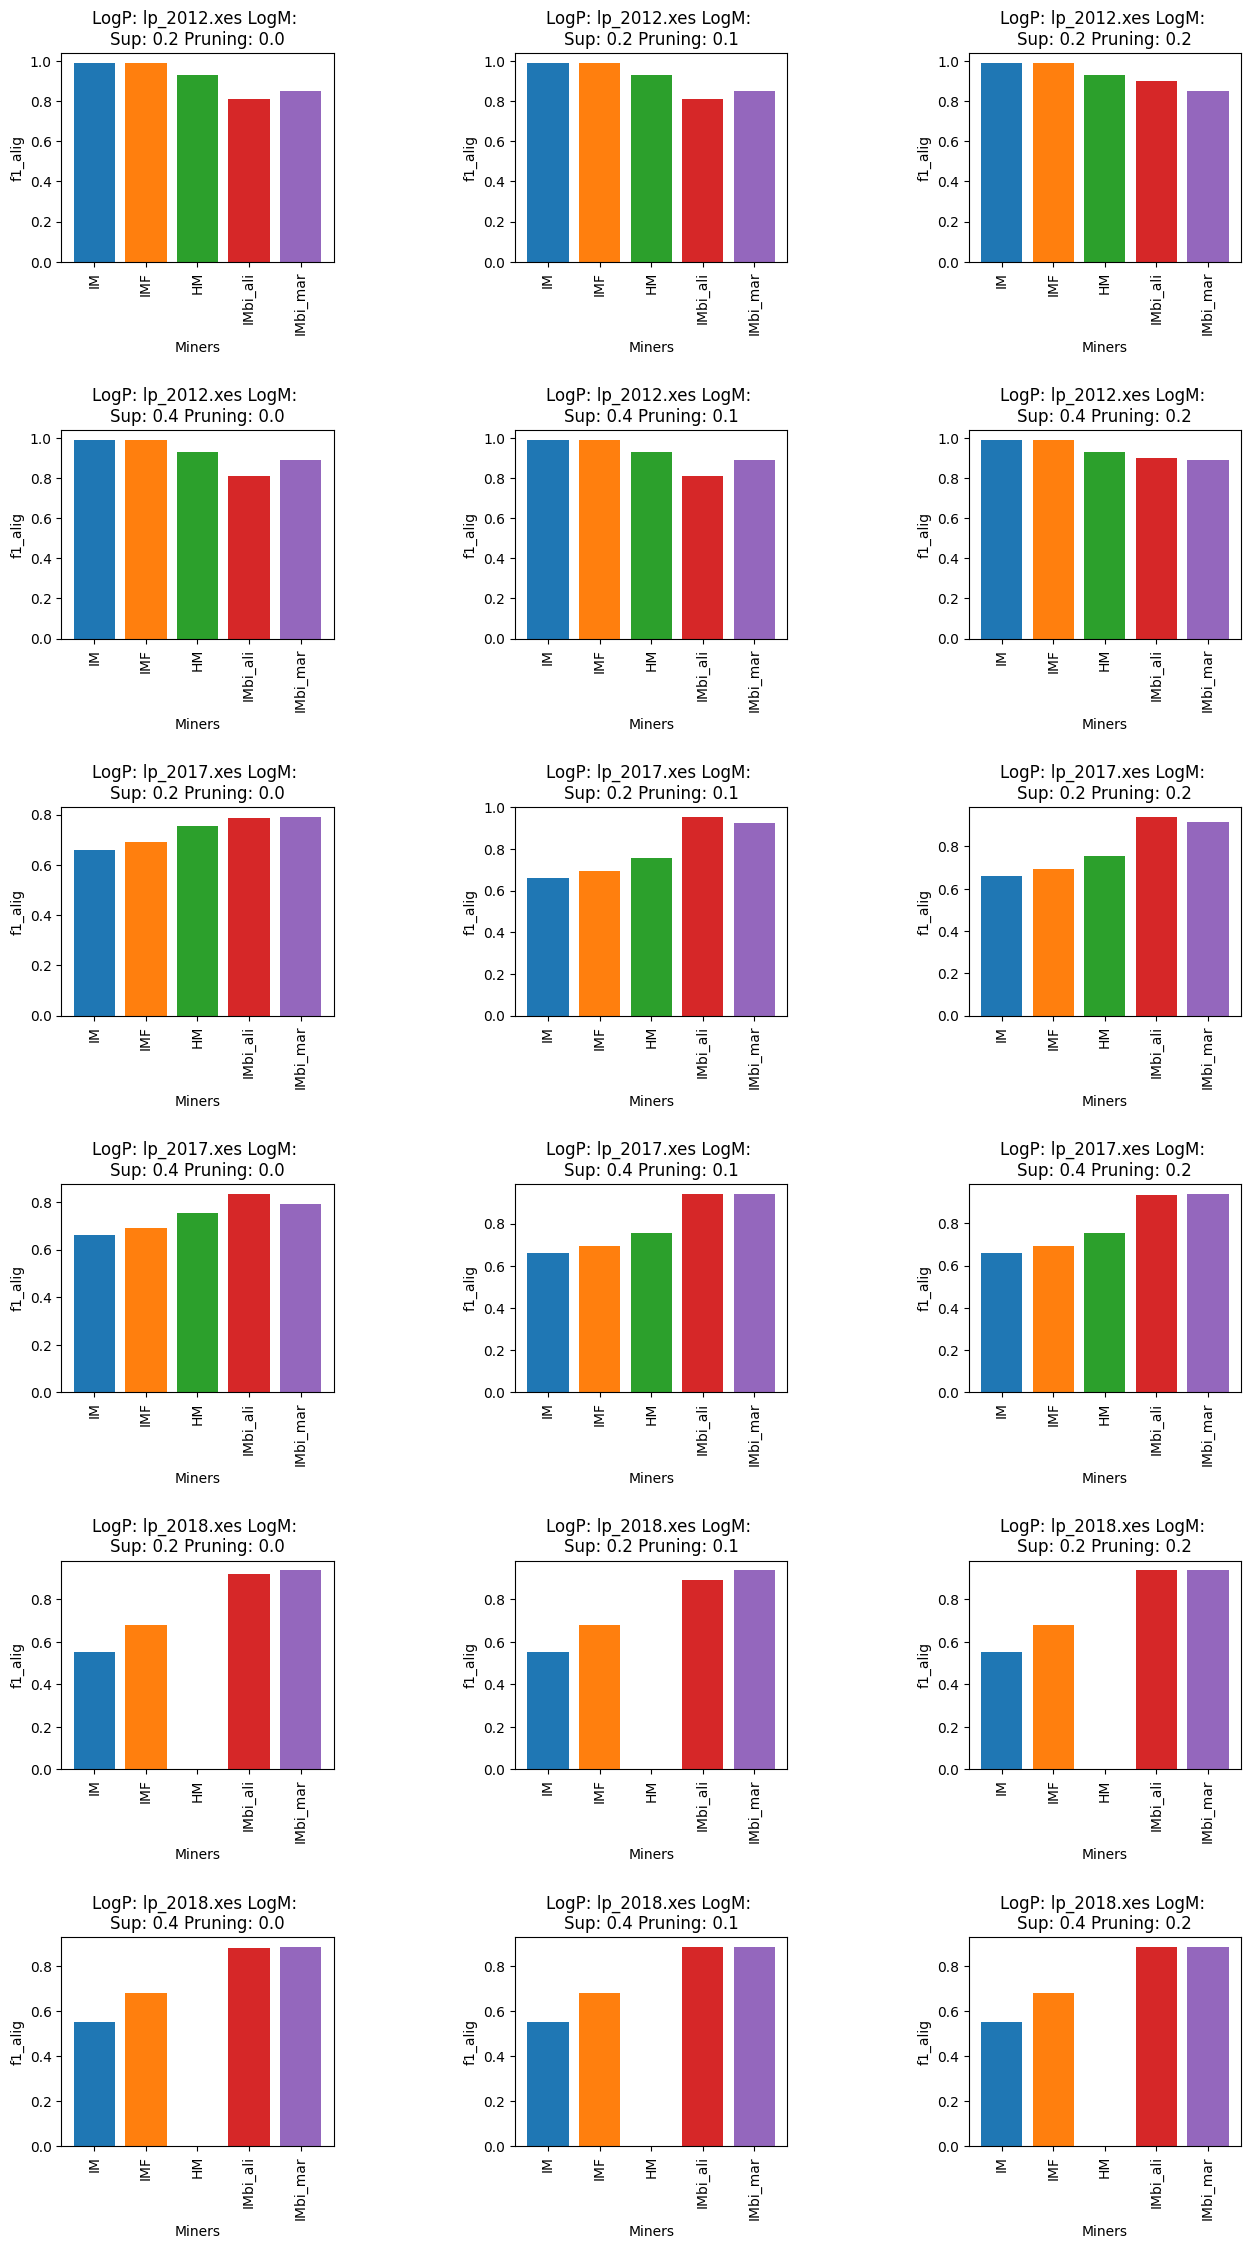

In [19]:
if runSingleLog == False:
  displayDoubleLog(df)
else:
  displaySingleLog(df)

In [20]:
if False:
  if runSingleLog == False:
    visualize_petriNet(df, "IM", "lp_2012.xes", "")
    visualize_petriNet(df, "IMbi_mar", "lp_2012", "lm_2012")
    visualize_petriNet(df, "IMbi_ali", "lp_2012", "lm_2012")
  else:
    visualize_petriNet(df, "IM", "lp_2012.xes", "")
    visualize_petriNet(df, "IMbi_mar", "lp_2012.xes", "")
    visualize_petriNet(df, "IMbi_ali", "lp_2012.xes", "")


In [21]:
if False:
  display(df)

from pm4py.objects.petri_net.exporter import exporter as pnml_exporter

net, im, fm = df.iloc[4].net, df.iloc[4].im, df.iloc[4].fm
view_petri_net(net, im, fm)
pnml_exporter.apply(net, im, "petri_IMbi.pnml", final_marking=fm)